In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc,  classification_report
pd.set_option('max_columns', 50)
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

<a href='https://www.dropbox.com/s/ivtt51dltfl8x6t/Crimes_chi.csv?dl=0'>Crime data link</a> and <a href='https://www.dropbox.com/s/ua8ecueeg0h71rd/weather.csv?dl=0'>weather data link</a> for the following analysis

In [2]:
#crimes=pd.read_csv('data/crime/crimes_chi.csv')
crimes=pd.read_csv('data/crime/crimes_chi.csv')

In [2]:
# Read weather data
weather=pd.read_csv('data/crime/weather.csv', index_col=0)

In [8]:
crimes.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6478356 entries, 0 to 6478355
Data columns (total 22 columns):
ID                      6478356 non-null int64
Case Number             6478352 non-null object
Date                    6478356 non-null object
Block                   6478356 non-null object
IUCR                    6478356 non-null object
Primary Type            6478356 non-null object
Description             6478356 non-null object
Location Description    6475409 non-null object
Arrest                  6478356 non-null bool
Domestic                6478356 non-null bool
Beat                    6478356 non-null int64
District                6478307 non-null float64
Ward                    5863502 non-null float64
Community Area          5862326 non-null float64
FBI Code                6478356 non-null object
X Coordinate            6391699 non-null float64
Y Coordinate            6391699 non-null float64
Year                    6478356 non-null int64
Updated On              6

In [3]:
weather.head()

,index,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,weather_type,date
0,0,41.995,-87.9336,201.8,2001-01-01,0.0,0.0,17.0,14.5,24.0,5.0,Unknown,2001-01-01
1,1,41.995,-87.9336,201.8,2001-01-02,0.0,0.0,15.0,12.0,19.0,5.0,Unknown,2001-01-02
2,2,41.995,-87.9336,201.8,2001-01-03,0.0,0.0,14.0,17.5,28.0,7.0,"['Fog, ice fog, or freezing fog', 'Mist', 'Sno...",2001-01-03
3,3,41.995,-87.9336,201.8,2001-01-04,0.0,0.0,14.0,24.5,30.0,19.0,"['Fog, ice fog, or freezing fog', 'Smoke or ha...",2001-01-04
4,4,41.995,-87.9336,201.8,2001-01-05,0.0,0.0,13.0,28.5,36.0,21.0,['Smoke or haze'],2001-01-05


In [3]:
weather.drop('index', axis=1, inplace=True)

In [3]:
crimes.dropna(inplace=True)

In [4]:
# Drop some columns/features that won't help with the prediction model
columns=['ID', 'Case Number', 'Block', 'IUCR', 'Description', 'Arrest', 'FBI Code', 'X Coordinate', 'Y Coordinate',
         'Year', 'Updated On', 'Location']
crimes.drop(columns, axis=1, inplace=True)

In [5]:
crimes.reset_index(drop=True, inplace=True)

In [7]:
crimes.head(3)

,Date,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude
0,01/31/2006 12:13:05 PM,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",False,2432,24.0,40.0,1.0,42.002478,-87.669297
1,03/21/2006 07:00:00 PM,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),False,825,8.0,15.0,66.0,41.780595,-87.683676
2,02/09/2006 01:44:41 AM,NARCOTICS,STREET,False,711,7.0,20.0,68.0,41.787955,-87.634037


In [8]:
# Extract hour from the 'Date' column and then drop the 'Date' column but keep the 'Year' column
crimes['Date']=pd.to_datetime(crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')

In [14]:
crimes['Month']=crimes['Date'].dt.month
crimes['Day']=crimes['Date'].dt.weekday
crimes['Hour']=crimes['Date'].dt.hour
crimes['DATE']=crimes['Date'].dt.strftime('%Y-%m-%d')

In [15]:
crimes.head()

,Date,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Month,Day,Hour,DATE
0,2006-01-31 12:13:05,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",False,2432,24.0,40.0,1.0,42.002478,-87.669297,1,1,12,2006-01-31
1,2006-03-21 19:00:00,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),False,825,8.0,15.0,66.0,41.780595,-87.683676,3,1,19,2006-03-21
2,2006-02-09 01:44:41,NARCOTICS,STREET,False,711,7.0,20.0,68.0,41.787955,-87.634037,2,3,1,2006-02-09
3,2006-03-21 16:45:00,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,1121,11.0,26.0,23.0,41.901774,-87.709415,3,1,16,2006-03-21
4,2006-03-21 22:00:00,THEFT,STREET,False,631,6.0,8.0,44.0,41.748675,-87.599049,3,1,22,2006-03-21


In [16]:
# We will mainly use community area since it's what the census uses for conducting surveys about Chicago
# First make a copy of crimes for machine learning use
crimes_ml=crimes.copy()

In [18]:
crimes_ml.head()

,Date,Primary Type,Location Description,Domestic,Beat,District,Ward,Community Area,Latitude,Longitude,Month,Day,Hour,DATE
0,2006-01-31 12:13:05,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",False,2432,24.0,40.0,1.0,42.002478,-87.669297,1,1,12,2006-01-31
1,2006-03-21 19:00:00,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),False,825,8.0,15.0,66.0,41.780595,-87.683676,3,1,19,2006-03-21
2,2006-02-09 01:44:41,NARCOTICS,STREET,False,711,7.0,20.0,68.0,41.787955,-87.634037,2,3,1,2006-02-09
3,2006-03-21 16:45:00,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,1121,11.0,26.0,23.0,41.901774,-87.709415,3,1,16,2006-03-21
4,2006-03-21 22:00:00,THEFT,STREET,False,631,6.0,8.0,44.0,41.748675,-87.599049,3,1,22,2006-03-21


In [19]:
crimes_ml.drop(['Date', 'Beat', 'District', 'Ward'], axis=1, inplace=True)

In [20]:
crimes_ml.head()

,Primary Type,Location Description,Domestic,Community Area,Latitude,Longitude,Month,Day,Hour,DATE
0,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",False,1.0,42.002478,-87.669297,1,1,12,2006-01-31
1,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),False,66.0,41.780595,-87.683676,3,1,19,2006-03-21
2,NARCOTICS,STREET,False,68.0,41.787955,-87.634037,2,3,1,2006-02-09
3,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,23.0,41.901774,-87.709415,3,1,16,2006-03-21
4,THEFT,STREET,False,44.0,41.748675,-87.599049,3,1,22,2006-03-21


In [21]:
# The 'Primary Type' is the response or target to predict. other columns are features and most are categorical.
# We need to convert those to numbers using oneHotEncoder
crimes_ml['Community Area']=crimes_ml['Community Area'].astype(int)

In [22]:
crimes_ml=crimes_ml[crimes_ml['Community Area']!=0]

In [23]:
crimes_ml.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782809 entries, 0 to 5782875
Data columns (total 10 columns):
Primary Type            5782809 non-null object
Location Description    5782809 non-null object
Domestic                5782809 non-null bool
Community Area          5782809 non-null int32
Latitude                5782809 non-null float64
Longitude               5782809 non-null float64
Month                   5782809 non-null int64
Day                     5782809 non-null int64
Hour                    5782809 non-null int64
DATE                    5782809 non-null object
dtypes: bool(1), float64(2), int32(1), int64(3), object(3)
memory usage: 424.6+ MB


In [24]:
# Merge weather data
crimes_ml=crimes_ml.merge(weather, on='DATE', how='left')

In [25]:
crimes_ml.head()

,Primary Type,Location Description,Domestic,Community Area,Latitude,Longitude,Month,Day,Hour,DATE,LATITUDE,LONGITUDE,ELEVATION,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,weather_type,date
0,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",False,1,42.002478,-87.669297,1,1,12,2006-01-31,41.995,-87.9336,201.8,0.00,0.0,0.0,34.0,38.0,30.0,Unknown,2006-01-31
1,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),False,66,41.780595,-87.683676,3,1,19,2006-03-21,41.995,-87.9336,201.8,0.00,0.0,0.0,29.5,33.0,26.0,Unknown,2006-03-21
2,NARCOTICS,STREET,False,68,41.787955,-87.634037,2,3,1,2006-02-09,41.995,-87.9336,201.8,0.02,0.3,0.0,24.0,32.0,16.0,"['Fog, ice fog, or freezing fog', 'Mist', 'Sno...",2006-02-09
3,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,23,41.901774,-87.709415,3,1,16,2006-03-21,41.995,-87.9336,201.8,0.00,0.0,0.0,29.5,33.0,26.0,Unknown,2006-03-21
4,THEFT,STREET,False,44,41.748675,-87.599049,3,1,22,2006-03-21,41.995,-87.9336,201.8,0.00,0.0,0.0,29.5,33.0,26.0,Unknown,2006-03-21


In [26]:
# Drop irrelevant columns and just keep average temperatures from the weather data (weather type has too many 'unknown')
crimes_ml.drop(['LATITUDE', 'LONGITUDE', 'ELEVATION', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'weather_type', 'date'], 
               axis=1, inplace=True)

In [27]:
crimes_ml.head()

,Primary Type,Location Description,Domestic,Community Area,Latitude,Longitude,Month,Day,Hour,DATE,TAVG
0,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",False,1,42.002478,-87.669297,1,1,12,2006-01-31,34.0
1,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),False,66,41.780595,-87.683676,3,1,19,2006-03-21,29.5
2,NARCOTICS,STREET,False,68,41.787955,-87.634037,2,3,1,2006-02-09,24.0
3,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,23,41.901774,-87.709415,3,1,16,2006-03-21,29.5
4,THEFT,STREET,False,44,41.748675,-87.599049,3,1,22,2006-03-21,29.5


In [15]:
crimes_ml.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782809 entries, 0 to 5782808
Data columns (total 11 columns):
Primary Type            5782809 non-null object
Location Description    5782809 non-null object
Domestic                5782809 non-null bool
Community Area          5782809 non-null int32
Latitude                5782809 non-null float64
Longitude               5782809 non-null float64
Month                   5782809 non-null int64
Day                     5782809 non-null int64
Hour                    5782809 non-null int64
DATE                    5782809 non-null object
TAVG                    5782809 non-null float64
dtypes: bool(1), float64(3), int32(1), int64(3), object(3)
memory usage: 468.8+ MB


To create features for machine learning, I will group months into seasons, days into weekdays and weekends, and hours into day time, night, late night, and early morning because they can catpure more of the pattern than individual values.

In [49]:
# Create three functions to group months and days.
def month_to_season(m):
    if m in [12,1,2]:
        m='Winter'
    elif m in [3,4,5]:
        m='Spring'
    elif m in [6,7,8]:
        m='Summer'
    elif m in [9,10,11]:
        m='Fall'
    return(m)

def weekdays(d):
    if d in [0,1,2,3,4]:
        d='Weekday'
    else:
        d='Weekend'
    return(d)

In [50]:
# Save months and days values so that we can always set them back if we need to
months=crimes_ml['Month']
days=crimes_ml['Day']
crimes_ml['Month']=crimes_ml['Month'].apply(month_to_season)
crimes_ml['Day']=crimes_ml['Day'].apply(weekdays)

In [51]:
crimes_ml.head()

,Primary Type,Location Description,Domestic,Community Area,Latitude,Longitude,Month,Day,Hour,DATE,TAVG
0,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",False,1,42.002478,-87.669297,Winter,Weekday,12,2006-01-31,34.0
1,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),False,66,41.780595,-87.683676,Spring,Weekday,19,2006-03-21,29.5
2,NARCOTICS,STREET,False,68,41.787955,-87.634037,Winter,Weekday,1,2006-02-09,24.0
3,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,False,23,41.901774,-87.709415,Spring,Weekday,16,2006-03-21,29.5
4,THEFT,STREET,False,44,41.748675,-87.599049,Spring,Weekday,22,2006-03-21,29.5


In [52]:
crimes_ml.to_csv('data/crime/crimes_ml.csv')

In [2]:
crimes_ml=pd.read_csv('data/crime/crimes_ml.csv', index_col=0)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [54]:
crimes_ml['Day'].value_counts()

Weekday    4174412
Weekend    1608397
Name: Day, dtype: int64

In [44]:
by_community_area=crimes_ml.groupby('Community Area')['Primary Type'].value_counts()

In [45]:
by_community_area.head

method

In [47]:
by_community_area=pd.DataFrame(by_community_area)

In [54]:
by_community_area=by_community_area.unstack(level=1, fill_value=0)

In [55]:
by_community_area.head()

Primary Type                           \
Primary Type          ARSON ASSAULT BATTERY BURGLARY   
Community Area                                         
1                        87    5202   16486     4767   
2                        95    3847   11181     5430   
3                        66    5195   14338     3325   
4                        36    1996    6099     2867   
5                        44    1422    3594     3381   

                                                                      \
Primary Type   CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Community Area                                                         
1                                              0                 379   
2                                              1                 233   
3                                              1                 398   
4                                              1                 139   
5                                              0                 113   

                                                                              \
Primary Type   CRIMINAL DAMAGE CRIMINAL TRESPASS DECEPTIVE PRACTICE GAMBLING   
Community Area                                                                 
1                        10610              3576               3348      166   
2                        11245              1488               3046       68   
3                         7986              3465               4782       93   
4                         5898              1064               2045       54   
5                         4860              1597               2061       29   

                                                                            \
Primary Type   HOMICIDE HUMAN TRAFFICKING INTERFERENCE WITH PUBLIC OFFICER   
Community Area                                                               
1                    84                 0                              250   
2                    40                 0                              127   
3                    80                 0                              147   
4                    14                 0                               52   
5                    16                 0                               43   

                                                             \
Primary Type   INTIMIDATION KIDNAPPING LIQUOR LAW VIOLATION   
Community Area                                                
1                        44         68                  274   
2                        38         87                  196   
3                        40         45                  233   
4                        26         45                  177   
5                        38         32                  114   

                                                                          \
Primary Type   MOTOR VEHICLE THEFT NARCOTICS NON - CRIMINAL NON-CRIMINAL   
Community Area                                                             
1                             2537      9196              0            1   
2                             3582      3806              0            1   
3                             2831     10422              0            3   
4                             1933      1680              0            2   
5                             1577      1394              0            1   

                                                           \
Primary Type   NON-CRIMINAL (SUBJECT SPECIFIED) OBSCENITY   
Community Area                                              
1                                             0         8   
2                                             1        12   
3                                             0         5   
4                                             0         3   
5                                             0        10   

                                                                    \
Primary Type   OFFENSE INVOLVING CHILDREN OTHER NA

In [7]:
crime_types=crimes_ml['Primary Type'].unique().tolist()

In [11]:
crime_types.index('SEX OFFENSE')

21

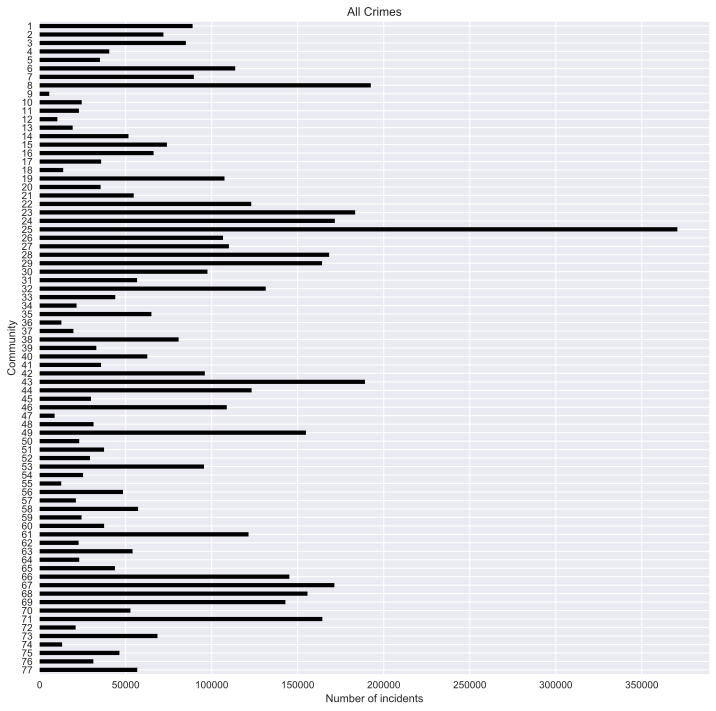

In [14]:
plt.figure(figsize=(12,12))
crimes_ml['Community Area'].value_counts().sort_index(ascending=False).plot(kind='barh', color='black')
plt.xlabel('Number of incidents')
plt.ylabel('Community')
plt.title('All Crimes')
plt.show()

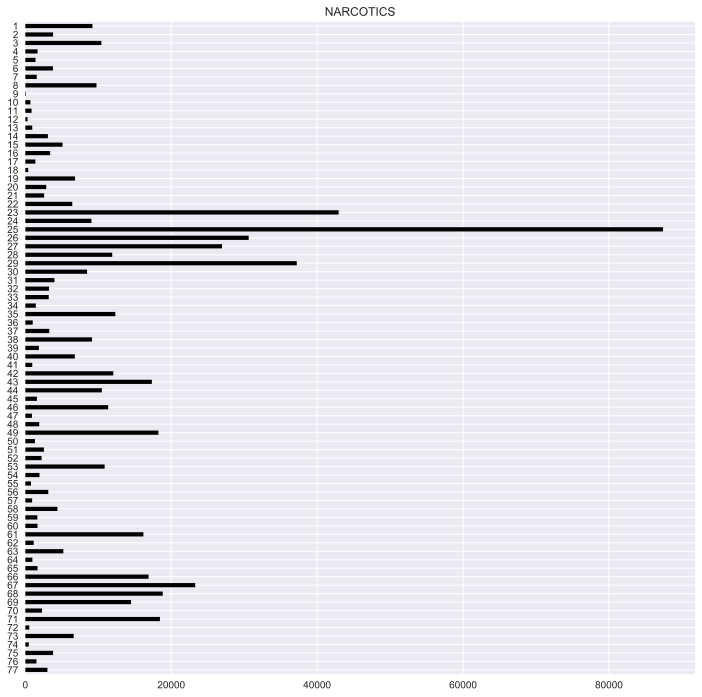

In [10]:
# See if different communities have different crime counts
select=crime_types[0]
plt.figure(figsize=(12,12))
crimes_ml[crimes_ml['Primary Type']==select]['Community Area'].value_counts().sort_index(ascending=False).plot(kind='barh', 
                                                                                                               color='black')
plt.title(select)
plt.show()

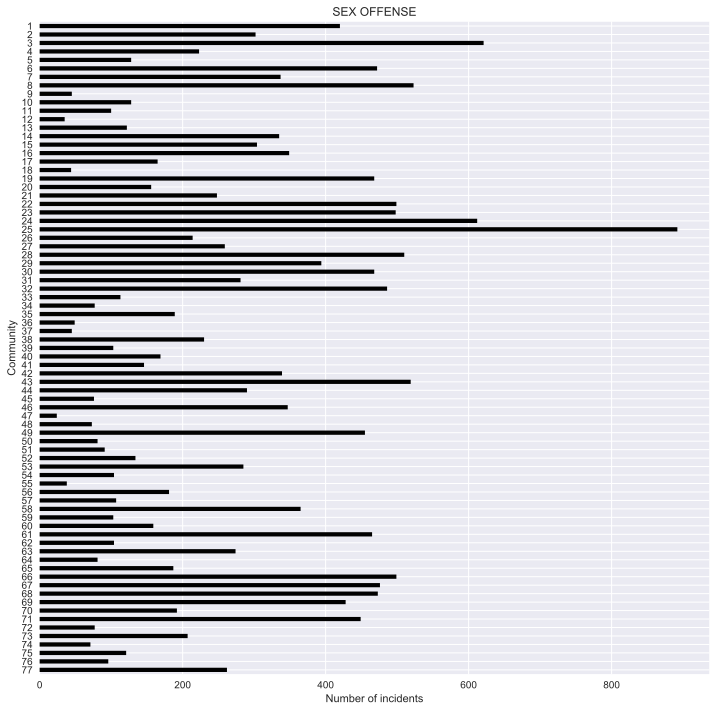

In [13]:
select=crime_types[21]
plt.figure(figsize=(12,12))
crimes_ml[crimes_ml['Primary Type']==select]['Community Area'].value_counts().sort_index(ascending=False).plot(kind='barh',
                                                                                                               color='black')
plt.xlabel('Number of incidents')
plt.ylabel('Community')
plt.title(select)
plt.show()

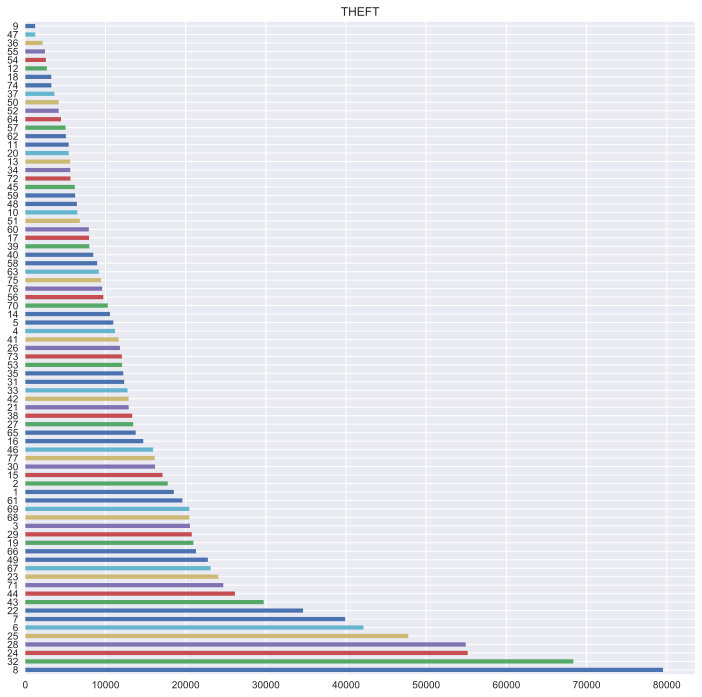

In [62]:
select=crime_types[2]
plt.figure(figsize=(12,12))
crimes_ml[crimes_ml['Primary Type']==select]['Community Area'].value_counts().plot(kind='barh')
plt.title(select)
plt.show()

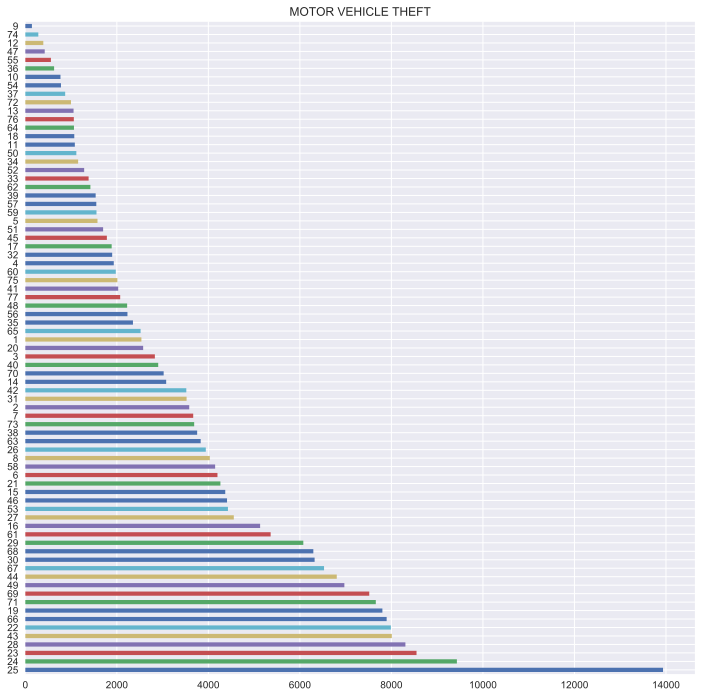

In [63]:
select=crime_types[3]
plt.figure(figsize=(12,12))
crimes_ml[crimes_ml['Primary Type']==select]['Community Area'].value_counts().plot(kind='barh')
plt.title(select)
plt.show()

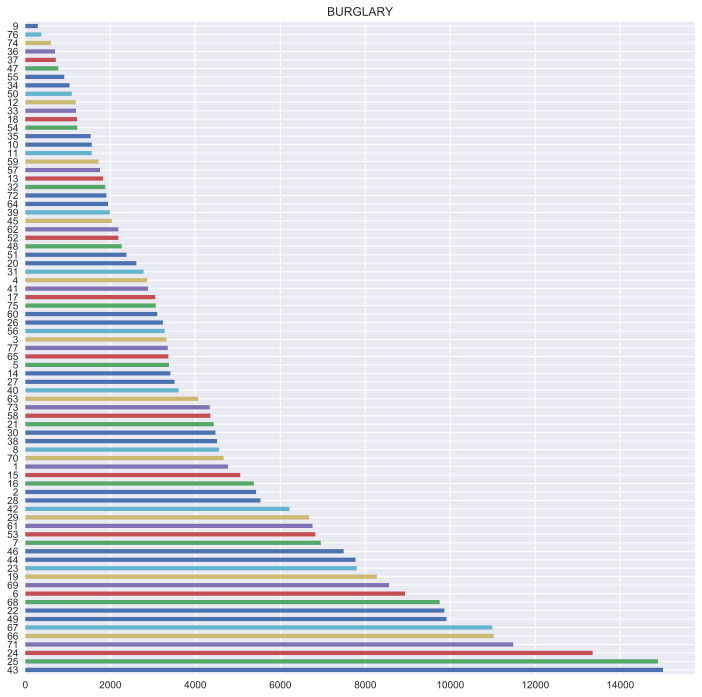

In [64]:
select=crime_types[11]
plt.figure(figsize=(12,12))
crimes_ml[crimes_ml['Primary Type']==select]['Community Area'].value_counts().plot(kind='barh')
plt.title(select)
plt.show()

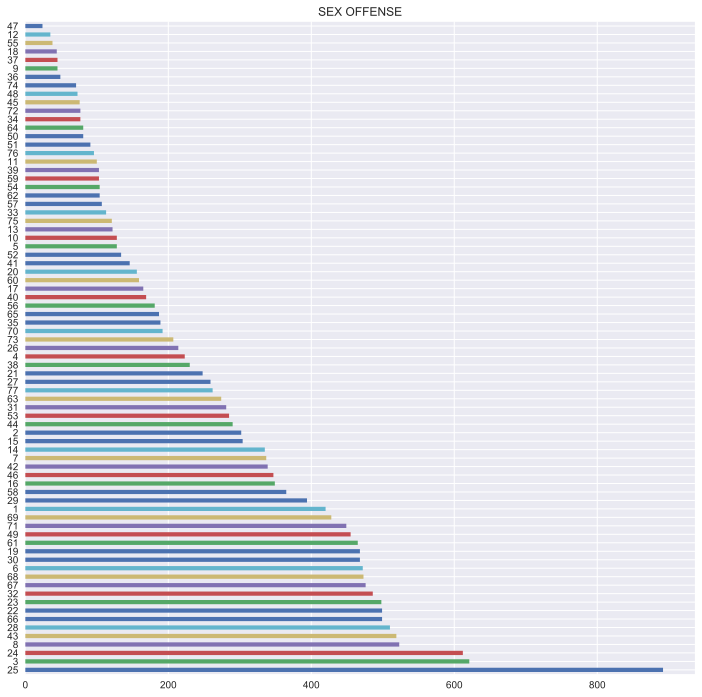

In [65]:
select='SEX OFFENSE'
plt.figure(figsize=(12,12))
crimes_ml[crimes_ml['Primary Type']==select]['Community Area'].value_counts().plot(kind='barh')
plt.title(select)
plt.show()

In [18]:
# Let's try one vs rest prediction to simplify things since there are way too many levels in the crime types
# Define a function to convert the selected type to value 0 and all the rest to 1
def one_vs_rest_conv(crime, column):
    converted=[]
    for c in column:
        if c==crime:
            c=0
        else:
            c=1
        converted.append(c)
    return(converted)

In [3]:
crime_types=crimes_ml['Primary Type'].unique().tolist()

In [19]:
# Let's convert all crime types using the above function and store them in a dictionary
all_crimes_converted={}
for crime_type in crime_types:
    crimes_converted=one_vs_rest_conv(crime_type, crimes_ml['Primary Type'])
    all_crimes_converted[crime_type]=crimes_converted

In [22]:
# Let's save these conversions to a csv file for later use
all_crimes_encoded=pd.DataFrame(all_crimes_converted)
all_crimes_encoded.to_csv('data/crime/all_crimes_encoded.csv')

<a href='https://www.dropbox.com/s/j6sa9bqqh0t9vhl/all_crimes_encoded.csv?dl=0'>Data link</a> for the followin analysis

In [4]:
all_crimes_encoded=pd.read_csv('data/crime/all_crimes_encoded.csv', index_col=0)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [55]:
# Use labelencoder to tansform 'Location Description' and 'Domestic' columns too.
le=LabelEncoder()
loc_des=le.fit_transform(crimes_ml['Location Description'].values)
domes=le.fit_transform(crimes_ml['Domestic'].values)

In [56]:
crimes_encoded=pd.DataFrame({'Location Description': loc_des, 'Domestic': domes})

In [57]:
crimes_encoded.head()

,Domestic,Location Description
0,0,145
1,0,122
2,0,152
3,0,47
4,0,152


In [58]:
crimes_encoded['Community Area']=crimes_ml['Community Area'].values

In [59]:
crimes_encoded['Month']=crimes_ml['Month'].values
crimes_encoded['Day']=crimes_ml['Day'].values
crimes_encoded['Hour']=crimes_ml['Hour'].values

In [60]:
crimes_encoded.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782809 entries, 0 to 5782808
Data columns (total 6 columns):
Domestic                5782809 non-null int64
Location Description    5782809 non-null int64
Community Area          5782809 non-null int64
Month                   5782809 non-null object
Day                     5782809 non-null object
Hour                    5782809 non-null int64
dtypes: int64(4), object(2)
memory usage: 264.7+ MB


In [61]:
crimes_encoded['Month'].value_counts()

Summer    1629231
Fall      1486789
Spring    1448528
Winter    1218261
Name: Month, dtype: int64

In [62]:
for c in ['Community Area', 'Month', 'Day']:
    c_trans=le.fit_transform(crimes_ml[c].values)
    crimes_encoded[c]=c_trans

In [63]:
crimes_encoded['Latitude']=crimes_ml['Latitude'].values
crimes_encoded['Longitude']=crimes_ml['Longitude'].values

In [64]:
crimes_encoded['Temperature']=crimes_ml['TAVG']

In [65]:
crimes_encoded.head(3)

,Domestic,Location Description,Community Area,Month,Day,Hour,Latitude,Longitude,Temperature
0,0,145,0,3,0,12,42.002478,-87.669297,34.0
1,0,122,65,1,0,19,41.780595,-87.683676,29.5
2,0,152,67,3,0,1,41.787955,-87.634037,24.0


In [67]:
crimes_encoded['Day'].value_counts()

0    4174412
1    1608397
Name: Day, dtype: int64

In [68]:
crimes_encoded.to_csv('data/crime/crimes_encoded.csv')

<a href='https://www.dropbox.com/s/gxf0etckowtjef4/crimes_encoded.csv?dl=0'>Data link</a> for the followin analysis

In [5]:
crimes_encoded=pd.read_csv('data/crime/crimes_encoded.csv', index_col=0)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [69]:
# Here we can test for different crime types using our one vs rest strategy. Total crime types are 34.
test_crime=crime_types[0]
print('The crime type we are testing is: ', test_crime)
crimes_encoded['Crime Type']=all_crimes_encoded[test_crime]

The crime type we are testing is:  NARCOTICS


In [70]:
crimes_encoded.head()

,Domestic,Location Description,Community Area,Month,Day,Hour,Latitude,Longitude,Temperature,Crime Type
0,0,145,0,3,0,12,42.002478,-87.669297,34.0,0
1,0,122,65,1,0,19,41.780595,-87.683676,29.5,1
2,0,152,67,3,0,1,41.787955,-87.634037,24.0,0
3,0,47,22,1,0,16,41.901774,-87.709415,29.5,1
4,0,152,43,1,0,22,41.748675,-87.599049,29.5,1


<strong>Let's take the a random 500000 samples and do a test run of different models.</strong>

In [117]:
crimes_test=crimes_encoded.sample(500000, axis=0)

In [72]:
crimes_test['Month'].value_counts()

2    140779
0    128603
1    125304
3    105314
Name: Month, dtype: int64

In [118]:
# Let's use get_dummies to transform the categorical columns
categories=['Domestic', 'Location Description', 'Community Area', 'Month', 'Day', 'Hour']
all_categories_encoded={}
for category in categories:
    all_categories_encoded[category]=pd.get_dummies(crimes_test[category])

In [119]:
features_to_use=['Community Area', 'Hour', 'Location Description', 'Month', 'Day', 'Domestic']
features_list=[]
for feature in features_to_use:
    features_list.append(all_categories_encoded[feature].values)
MDH_features=np.concatenate(features_list, axis=1)

In [120]:
MDH_features.shape

(500000, 239)

In [121]:
crimes_test_categoricals=crimes_test.drop(['Domestic','Crime Type'], axis=1).values[:, 0:6]
crimes_test_numericals=crimes_test.drop(['Domestic','Crime Type'], axis=1).values[:, 6:]

In [122]:
# To make X, y values for different models
X=np.concatenate((MDH_features, crimes_test_numericals), axis=1)
y=crimes_test['Crime Type'].values
# split into train and test data
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, stratify=y)

In [123]:
X_train.shape

(400000, 242)

In [79]:
scaler=StandardScaler()

In [124]:
location_temp_train=scaler.fit_transform(X_train[:, 243:])

In [125]:
location_temp_train.shape

(400000, 3)

In [126]:
X_train.shape

(400000, 242)

In [127]:
# Column index 198 to 200 are the 3 numerical columns. Let's combine the categorical features with the scaled numerical features
X_train_transformed=np.concatenate((X_train[:, 0:243], location_temp_train), axis=1)

In [128]:
X_train_transformed.shape

(400000, 242)

In [85]:
crimes_test['Crime Type'].value_counts()

1    446229
0     53771
Name: Crime Type, dtype: int64

In [129]:
logreg=LogisticRegression(class_weight='balanced')

In [130]:
params_grid={'C': [0.001, 0.01, 0.1, 1, 10,100]}

In [131]:
logreg_cv=GridSearchCV(logreg, params_grid)

In [132]:
logreg_cv.fit(X_train_transformed, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [133]:
logreg_cv.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [134]:
location_temp_test=scaler.fit_transform(X_test[:, 243:])

In [135]:
X_test_transformed=np.concatenate((X_test[:, 0:243], location_temp_test), axis=1)

In [136]:
X_test_transformed.shape

(100000, 242)

In [137]:
logreg_cv.score(X_test_transformed, y_test)

0.73841999999999997

In [138]:
logreg_cv_pred=logreg_cv.predict(X_test_transformed)

In [96]:
pd.Series(y_test).value_counts()

1    89246
0    10754
dtype: int64

In [139]:
cm=confusion_matrix(y_test, logreg_cv_pred)
print(cm)

[[ 8483  2286]
 [23872 65359]]


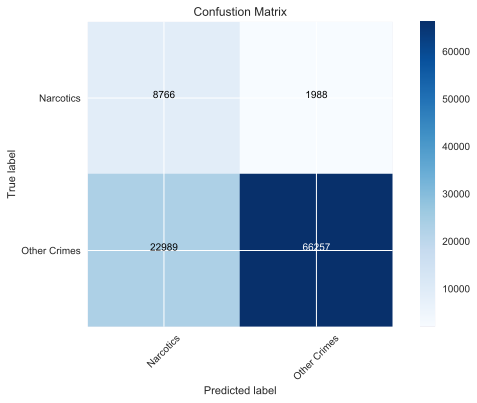

In [116]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confustion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Narcotics', 'Other Crimes'], rotation=45)
plt.yticks(tick_marks, ['Narcotics', 'Other Crimes'])
fmt='d'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [115]:
precision_score(y_test, logreg_cv_pred)

0.97086966078100956

In [102]:
recall_score(y_test, logreg_cv_pred)

0.7424086233556686

In [103]:
print(classification_report(y_test, logreg_cv_pred, target_names=['Narcotics', 'Other crimes']))

              precision    recall  f1-score   support

   Narcotics       0.28      0.82      0.41     10754
Other crimes       0.97      0.74      0.84     89246

 avg / total       0.90      0.75      0.80    100000



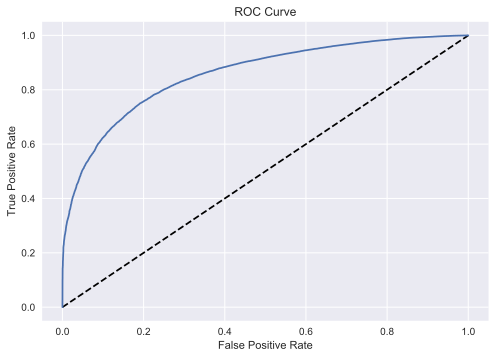

In [104]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg_cv.predict_proba(X_test_transformed)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [106]:
print('Area under curve is: ', auc(fpr, tpr))

Area under curve is:  0.85835622162
